In this notebook, I investigate how sensitive `scipy.stats.gaussian_kde` is to outliers and test different methods for addressing outliers

In [1]:
import matplotlib.pyplot as plt
import numpy as np


from scipy import stats

## Generate synthetic data
Sample from 2D Gaussian, then throw in some outliers

In [2]:
num_ID = 950 # ID stands for in distribution
num_OOD = 50 # OOD stands for out of distribution

# Sample ID (2D Gaussian)
mean = [.1,.4]
cov = [[.1, 0], [0, .05]]
samples_ID = np.random.multivariate_normal(mean, cov, size=(num_ID,))

# # Sample OOD (Uniform [0, 1] x [0, 50])
samples_OOD = np.zeros((num_OOD, 2))
samples_OOD[:,0] = np.random.uniform(low=0, high=1, size=(num_OOD,))
samples_OOD[:,1] = np.random.uniform(low=0, high=50, size=(num_OOD,))


# Concatenate samples
samples = np.vstack((samples_ID, samples_OOD))

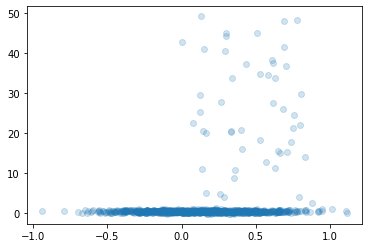

In [3]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.2)
plt.show()

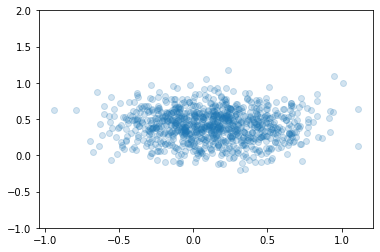

In [4]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.2)
plt.ylim(-1,2)
plt.show()

## Try fitting KDE

In [5]:
xmin, xmax = -1, 1
ymin, ymax = 0, 10

### Sanity check that `gaussian_kde` works the way I think it does

In [6]:
bins=50
cts, xedges, yedges, img = plt.hist2d(samples[:,0], samples[:,1], 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

kernel1 = stats.gaussian_kde(positions, weights=cts.T.ravel())

In [7]:
kernel2 = stats.gaussian_kde(samples.T)

In [8]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z1 = np.reshape(kernel1(positions).T, X.shape)
Z2 = np.reshape(kernel2(positions).T, X.shape)

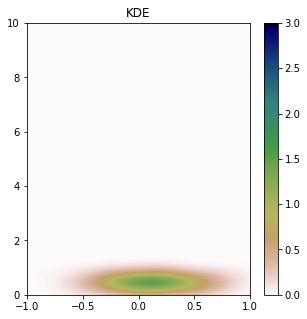

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z1), 
               aspect='auto',
               vmin=0, vmax=3, # Color map limits
               cmap=plt.cm.gist_earth_r,
               extent=[xmin, xmax, ymin, ymax])
ax.set_title('KDE')
fig.colorbar(im)
plt.show()

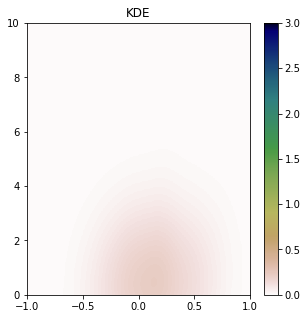

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z2), 
               aspect='auto',
               vmin=0, vmax=3, # Color map limits
               cmap=plt.cm.gist_earth_r,
               extent=[xmin, xmax, ymin, ymax])
ax.set_title('KDE')
fig.colorbar(im)
plt.show()

Hmm... When there are no outliers, it seems that passing in histogram bin locations and histogram counts produces the same result as passing in the raw data, provided that you use enough bins when computing the histogram

However, when there are outliers, the histogram method works much better

### Without outliers

In [11]:
bins=50
cts, xedges, yedges, img = plt.hist2d(samples_ID[:,0], samples_ID[:,1], 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

ground_truth_kernel = stats.gaussian_kde(positions, weights=cts.T.ravel())

In [12]:
# ground_truth_kernel = stats.gaussian_kde(samples_ID.T)

### With outliers

In [19]:
bins=50
cts, xedges, yedges, img = plt.hist2d(samples[:,0], samples[:,1], 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

kernel = stats.gaussian_kde(positions, weights=cts.T.ravel())

In [14]:
# kernel = stats.gaussian_kde(samples.T)

In [20]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

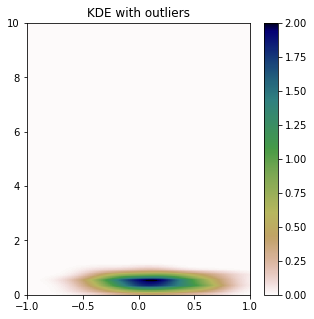

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               aspect='auto',
               vmin=0, vmax=2, # Color map limits
               cmap=plt.cm.gist_earth_r,
               extent=[xmin, xmax, ymin, ymax])
ax.set_title('KDE with outliers')
fig.colorbar(im)
plt.show()

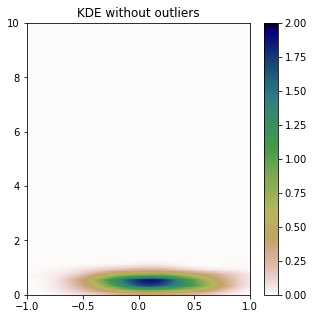

In [17]:
# Compare to ground truth
Z = np.reshape(ground_truth_kernel(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               aspect='auto',
               vmin=0, vmax=2, # Color map limits
               cmap=plt.cm.gist_earth_r,
               extent=[xmin, xmax, ymin, ymax])
ax.set_title('KDE without outliers')
fig.colorbar(im)
plt.show()